In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, auc
from IPython.display import clear_output
import os
import shutil
import re
from datetime import datetime, timedelta
import seaborn as sns
from jDataResultsAnalysis import explore_data_results, compare_data_results

dataset_path = "ctg_dataset/Old Dataset/"
#dataset_path = "ctg_dataset/Old Dataset (Cases Diff 3-7)/"
#dataset_path = "ctg_dataset/Old Dataset (Cases Diff 0-2)/"
#dataset_path = "ctg_dataset/Dataset with Folds/model_datasets/fold_0"

def min_max_normalize(signal, min_value, max_value):
    valid_mask = signal != -1 # Create a mask for non-missing values (-1 are missing values)
    signal[valid_mask] = (signal[valid_mask] - min_value) / (max_value - min_value) # Apply normalization only to valid values
    return signal

In [43]:
# Load the dataset
X_train_fhr = np.load(os.path.join(dataset_path, 'X_train_fhr.npy'))
X_train_toco = np.load(os.path.join(dataset_path, 'X_train_toco.npy'))
y_train = np.load(os.path.join(dataset_path, 'y_train.npy'))
clinical_train = pd.read_csv(os.path.join(dataset_path, 'clinical_train.csv'))
X_val_fhr = np.load(os.path.join(dataset_path, 'X_val_fhr.npy'))
X_val_toco = np.load(os.path.join(dataset_path, 'X_val_toco.npy'))
y_val = np.load(os.path.join(dataset_path, 'y_val.npy'))
clinical_val = pd.read_csv(os.path.join(dataset_path, 'clinical_val.csv'))

# Normalize using min-max normalization (ignoring -1)
X_train_fhr = min_max_normalize(X_train_fhr, 50.0, 240.0)
X_val_fhr = min_max_normalize(X_val_fhr, 50.0, 240.0)
X_train_toco = min_max_normalize(X_train_toco, 0.0, 100.0)
X_val_toco = min_max_normalize(X_val_toco, 0.0, 100.0)

# Merge FHR and TOCO into a single array with shape (N, 960, 2) and add to dataframes
X_train = np.stack((X_train_fhr, X_train_toco), axis=-1)  
X_val = np.stack((X_val_fhr, X_val_toco), axis=-1)   
clinical_train['input_signals'] = [x for x in X_train]
clinical_train['label'] = y_train.tolist()
clinical_val['input_signals'] = [x for x in X_val]
clinical_val['label'] = y_val.tolist()

print(clinical_train.shape, clinical_val.shape)
print('FHR range:', np.min(X_train[:,:,0]), '-', np.max(X_train[:,:,0]), '; -1s:', np.sum(X_train[:,:,0] == -1)/X_train[:,:,0].size)
print('TOCO range:', np.min(X_train[:,:,1]), '-', np.max(X_train[:,:,1]), '; -1s:', np.sum(X_train[:,:,1] == -1)/X_train[:,:,1].size)

(16471, 21) (4118, 21)
FHR range: -1 - 1 ; -1s: 0.34502509461072994
TOCO range: -1 - 1 ; -1s: 0.33759777285329773


In [45]:
# Manually set results_dir if needed 
results_dir = None 
#results_dir = f"{dataset_path}/tested 20241022 1555"

# Set results_dir to the most recent one
if results_dir is None:
    subdirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    valid_dirs = []
    for subdir in subdirs:
        # Check if the directory name starts with 'trained ' and try to parse the datetime part
        if subdir.startswith('trained '):
        #if subdir.startswith('finetuned '):
            try:
                datetime.strptime(subdir[len('trained '):], '%Y%m%d %H%M')  # Ignore the 'trained ' prefix
                valid_dirs.append(subdir)
            except ValueError:
                continue
    # Sort the valid directories by the datetime part
    valid_dirs_sorted = sorted(valid_dirs, key=lambda x: datetime.strptime(x[len('trained '):], '%Y%m%d %H%M'))
    if valid_dirs_sorted:
        results_dir = os.path.join(dataset_path, valid_dirs_sorted[-1])

# Load the split dataset, logs and results 
train_df = clinical_train.copy() #pd.read_csv(os.path.join(results_dir, 'dataset_train.csv'))
val_df = clinical_val.copy() #pd.read_csv(os.path.join(results_dir, 'dataset_test.csv'))
preds = np.load(os.path.join(results_dir, 'preds.npy'))
trues = np.load(os.path.join(results_dir, 'trues.npy'))
with open(os.path.join(results_dir, 'PatchTST_ctg_960.log'), 'r') as log_file:
    log_data = log_file.read()
print(results_dir)

ctg_dataset/Old Dataset/trained 20241009 0038


In [46]:
explore_data_results(train_df, name='train')
explore_data_results(val_df, name='test')

------------------------------------ train -------------------------------------
Count: 16471

                Column Type/Unique Values                                                                         Details
             StudyID_B            Numeric Min: 5716.00, Max: 400504.00, Mean: 298189.21, Median: 320867.00, Std: 89118.52
                 OMAGE            Numeric                   Min: 15.00, Max: 49.00, Mean: 30.66, Median: 31.00, Std: 5.82
                 OPAR1            Numeric                       Min: 0.00, Max: 6.00, Mean: 0.72, Median: 0.00, Std: 0.99
                 OPAR2            Numeric                      Min: 0.00, Max: 14.00, Mean: 0.47, Median: 0.00, Std: 0.91
               RecGest            Numeric                   Min: 27.00, Max: 41.00, Mean: 34.79, Median: 35.00, Std: 3.85
                  Diff            Numeric               Min: 0.00, Max: 2618.00, Mean: 392.81, Median: 84.00, Std: 582.22
                 BMI_M            Numeric          

******************** Hyperparameters ********************
activation: relu
affine: 0
batch_size: 48
c_out: 1
checkpoints: ./checkpoints/ctg
d_ff: 128
d_layers: 1
d_model: 512
data: CTG
dataset_path: ../ctg_dataset/Old Dataset
dec_in: 2
decomposition: 0
des: Exp
devices: 0,1,2,3
distil: True
do_predict: False
dropout: 0.1
e_layers: 6
embed: timeF
embed_type: 0
enc_in: 2
factor: 1
fc_dropout: 0.4
features: M
freq: h
gpu: 0
head_dropout: 0.2
individual: 0
is_optuna: False
is_training: 1
itr: 1
kernel_size: 15
learning_rate: 0.0001
loss: cross_entropy
lradj: type3
model: PatchTST
model_id: ctg_960
moving_avg: 25
n_heads: 4
num_classes: 2
num_workers: 10
output_attention: False
padding_patch: end
patch_len: 16
patience: 25
pct_start: 0.3
random_seed: 2021
revin: 1
root_path: ./dataset/
seq_len: 960
stride: 16
subtract_last: 0
target: OT
test_flop: False
train_epochs: 100
use_amp: False
use_gpu: True
use_multi_gpu: False

******************* Training Results ********************

Total Train

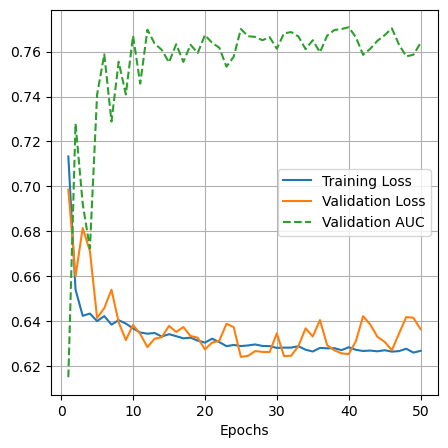

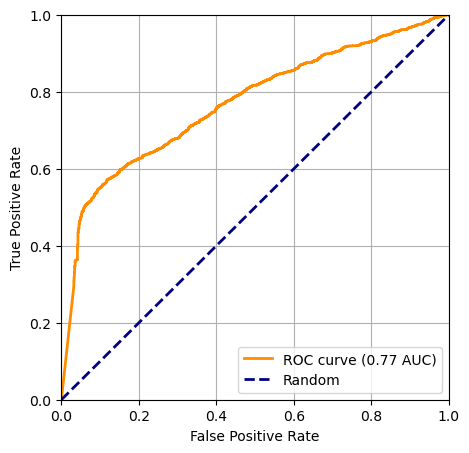

In [47]:
# Initialize variables to store log data
hyperparameters = {}
train_losses = []
val_losses = []
val_aucs = []
epochs = []
train_times = []
test_metrics = None

# Parse the log data directly from the variable
lines = log_data.splitlines()
for i, line in enumerate(lines):
    if i == 1 and line.startswith("Namespace("):
        hyperparameter_string = line.strip().replace("Namespace(", "").replace(")", "")
        hyperparameter_pairs = hyperparameter_string.split(", ")
        for item in hyperparameter_pairs:
            if "=" in item:
                key, value = item.split("=", 1)
                hyperparameters[key.strip()] = value.strip().strip("'")  # Remove quotes around string values

    # Extract training/validation losses and validation auc
    if "Train Loss" in line:
        match = re.findall(r'Epoch: (\d+).*Train Loss: ([\d.]+) Vali Loss: ([\d.]+) Vali AUC: ([\d.]+)', line)
        if match:
            epoch, train_loss, val_loss, val_auc = match[0]
            epochs.append(int(epoch))
            train_losses.append(float(train_loss))
            val_losses.append(float(val_loss))
            val_aucs.append(float(val_auc))
    
    # Extract training time
    if "cost time" in line:
        match = re.findall(r'Epoch: (\d+) cost time: ([\d.]+)', line)
        if match:
            epoch, time_taken = match[0]
            train_times.append(float(time_taken))
    
    # Extract final test metrics
    if "Accuracy" in line:
        match = re.findall(r'Accuracy:([\d.]+), AUC:([\d.]+), Sensitivity:([\d.]+), Specificity:([\d.]+), PPV:([\d.]+), NPV:([\d.]+), F1:([\d.]+)', line)
        if match:
            accuracy, auc_score, sensitivity, specificity, ppv, npv, f1 = match[0]
            test_metrics = {
                'Accuracy': float(accuracy),
                'AUC': float(auc_score),
                'Sensitivity': float(sensitivity),
                'Specificity': float(specificity),
                'PPV': float(ppv),
                'NPV': float(npv),
                'F1': float(f1)
            }

print("******************** Hyperparameters ********************")
for key, value in hyperparameters.items():
    print(f"{key}: {value}")

print("\n******************* Training Results ********************")

# Calculate and print total training time
total_train_time = sum(train_times)
train_time_hms = str(timedelta(seconds=total_train_time))
print(f"\nTotal Training Time: {train_time_hms}")

# Plot the training and validation losses
plt.figure(figsize=(5, 5))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, val_aucs, label='Validation AUC', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Print the final test results
if test_metrics:
    print("\n******************** Testing Results ********************")
    for metric, value in test_metrics.items():
        print(f"{metric}: {np.round(value, decimals=2)}")

# Compute ROC curve and AUC using already loaded preds and trues
fpr, tpr, _ = roc_curve(trues, preds)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve ({roc_auc:.2f} AUC)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [48]:
def classification_metrics(pred, true):

    # Calculate AUC
    auc = roc_auc_score(true, pred)
    
    # Compute ROC curve to find the optimal threshold using Youden's Index
    fpr, tpr, thresholds = roc_curve(true, pred)
    youdens_index = tpr - fpr
    optimal_threshold = thresholds[np.argmax(youdens_index)]
    
    # Apply the optimal threshold to convert probabilities to binary labels
    pred_labels = (pred >= optimal_threshold).astype(int)
    true_labels = true.astype(int)
    
    # Calculate confusion matrix to extract TP, TN, FP, FN
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Specificity (FPR = 1 - Specificity)
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0          # Positive Predictive Value (Precision)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0          # Negative Predictive Value
    f1 = f1_score(true_labels, pred_labels)                # F1 Score

    return optimal_threshold, accuracy, auc, sensitivity, specificity, ppv, npv, f1

Optimal threshold (Youden's index): 0.0003275733324699104
57.21649484536083% cases correctly classified
88.15426997245179% controls correctly classified
--------------------


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


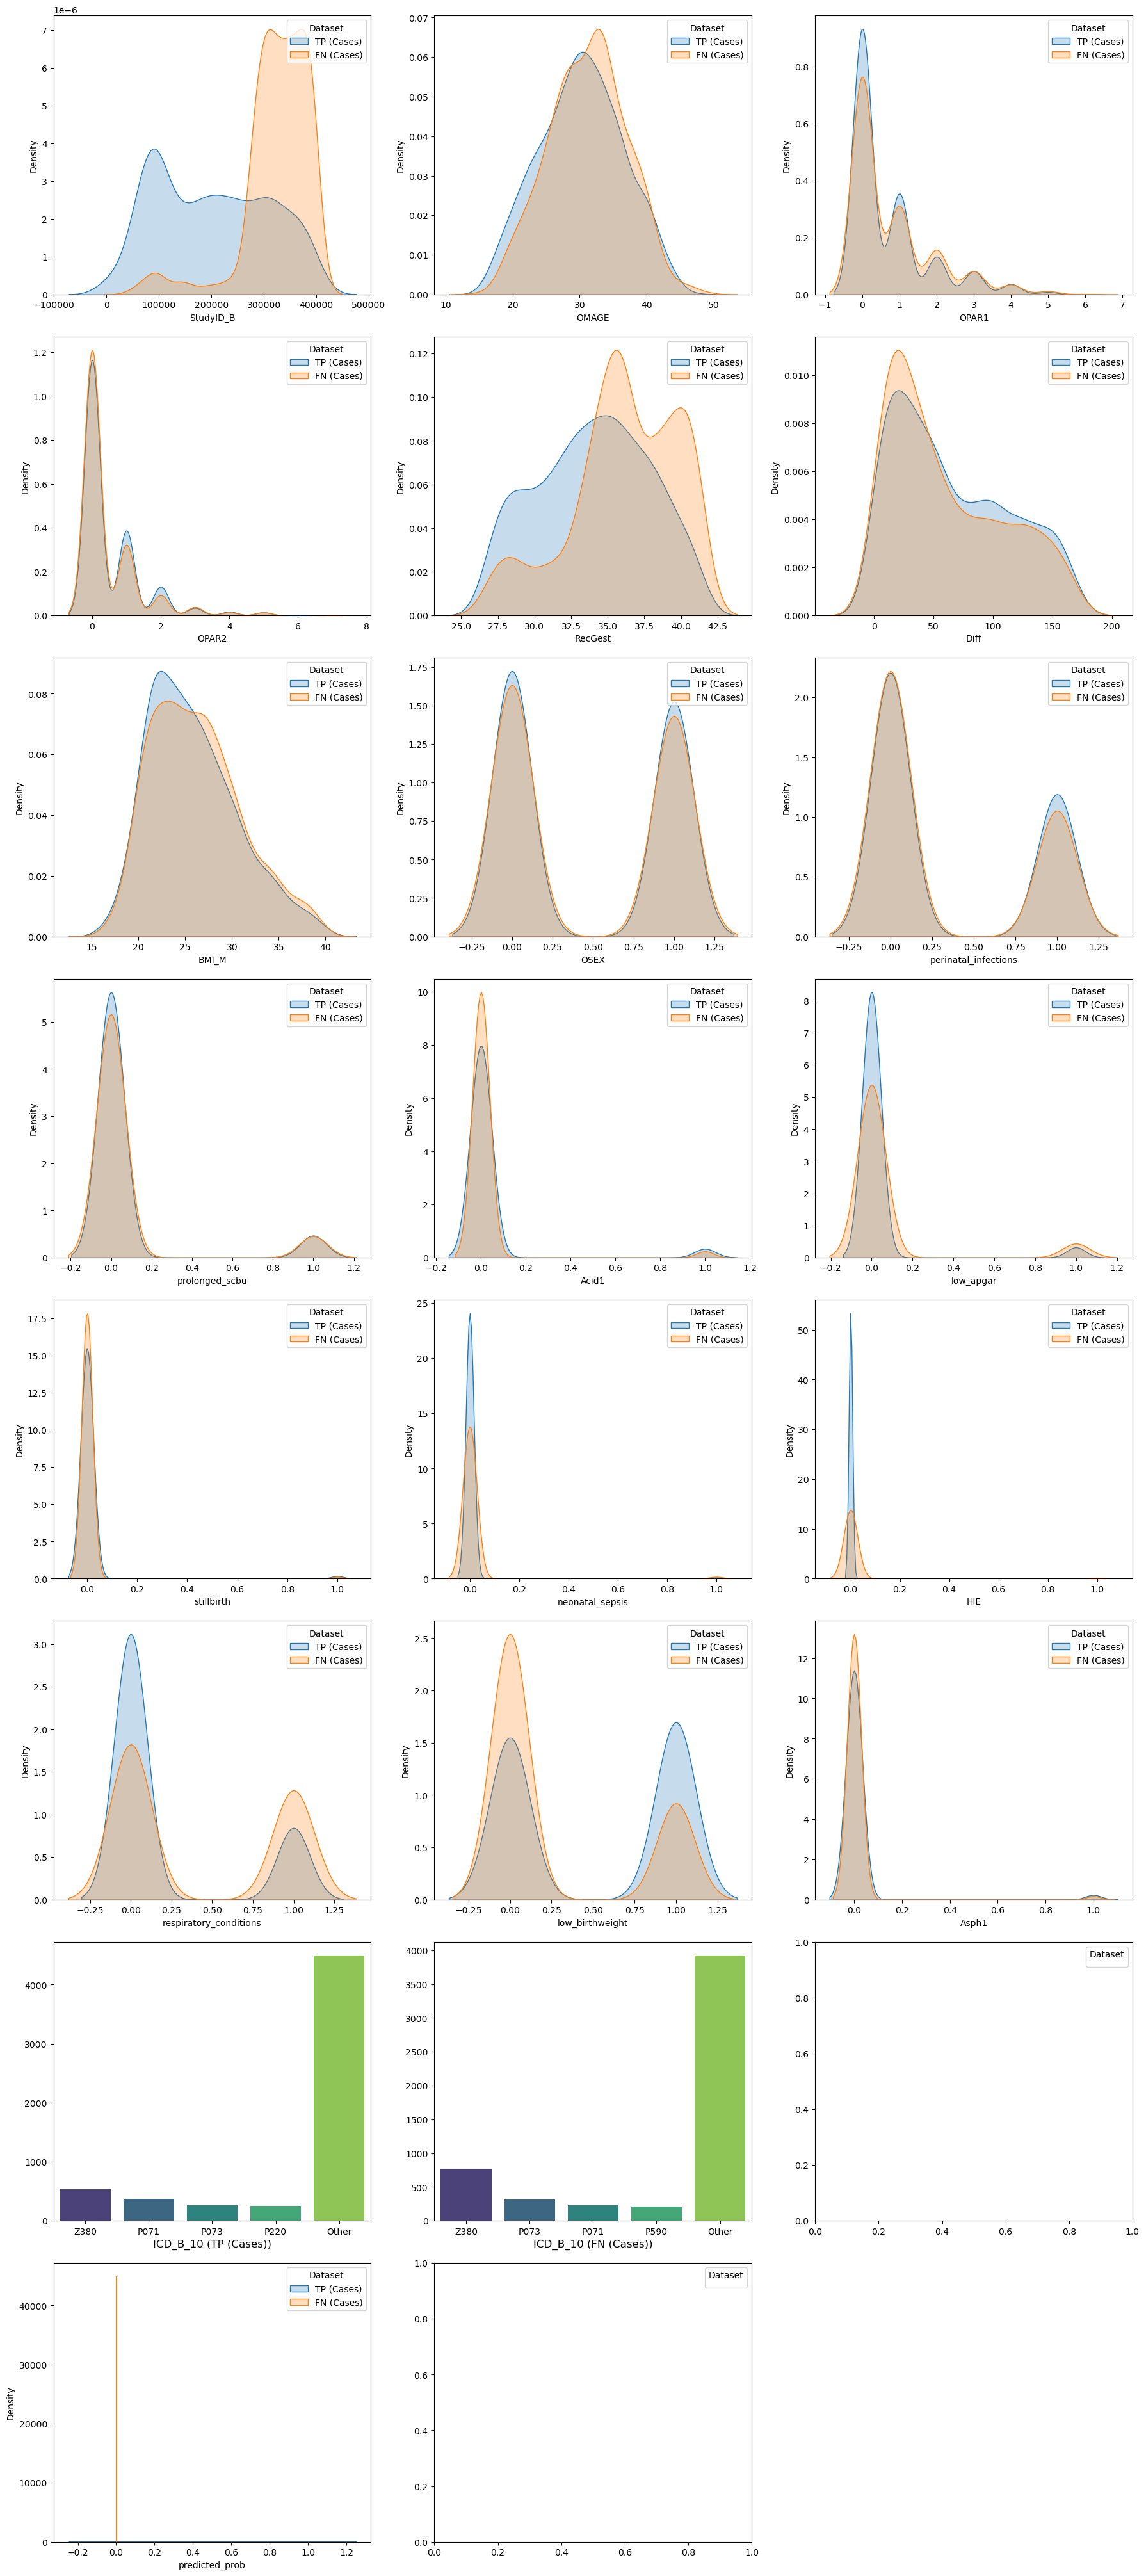

---------------------------------- TP (Cases) ----------------------------------
Count: 1110

                Column Type/Unique Values                                                                          Details
             StudyID_B            Numeric Min: 5736.00, Max: 397460.00, Mean: 201156.08, Median: 195833.50, Std: 107254.65
                 OMAGE            Numeric                    Min: 16.00, Max: 47.00, Mean: 30.25, Median: 30.00, Std: 6.22
                 OPAR1            Numeric                        Min: 0.00, Max: 5.00, Mean: 0.68, Median: 0.00, Std: 1.05
                 OPAR2            Numeric                        Min: 0.00, Max: 6.00, Mean: 0.52, Median: 0.00, Std: 0.92
               RecGest            Numeric                    Min: 27.00, Max: 41.00, Mean: 34.00, Median: 34.00, Std: 3.81
                  Diff            Numeric                   Min: 0.00, Max: 168.00, Mean: 65.62, Median: 54.00, Std: 48.26
                 BMI_M            Numeric    

In [49]:
# Calculate classification metrics and tuned threshold
optimal_threshold, accuracy, auc, sensitivity, specificity, ppv, npv, f1 = classification_metrics(preds, trues)

# Add the results to val_df
predicted_probs = preds.flatten()
predicted_labels = (predicted_probs > optimal_threshold).astype(int)
print(f"Optimal threshold (Youden's index): {optimal_threshold}")

val_df = val_df[:len(preds)]
val_df['predicted_prob'] = predicted_probs
val_df['predicted_label'] = predicted_labels

# Filtering by correctly classified and misclassified samples, as well as by label
test_cases = val_df[val_df['label'] == 1]
test_controls = val_df[val_df['label'] == 0]
correctly_classified_cases = val_df[(val_df['label'] == 1) & (val_df['label'] == val_df['predicted_label'])]
correctly_classified_controls = val_df[(val_df['label'] == 0) & (val_df['label'] == val_df['predicted_label'])]
misclassified_cases = val_df[(val_df['label'] == 1) & (val_df['label'] != val_df['predicted_label'])]
misclassified_controls = val_df[(val_df['label'] == 0) & (val_df['label'] != val_df['predicted_label'])]

print(f"{100*len(correctly_classified_cases)/len(test_cases)}% cases correctly classified")
print(f"{100*len(correctly_classified_controls)/len(test_controls)}% controls correctly classified")
print('-'*20)

# compare_data_results(correctly_classified_cases, misclassified_cases,
#                      correctly_classified_controls, misclassified_controls,
#                      names=['true-cases','false-cases','true-controls','false-controls'])

compare_data_results(correctly_classified_cases, misclassified_cases,
                     names=['TP (Cases)','FN (Cases)'])
explore_data_results(test_cases, name='Test (Cases)')

Diff < 1 days (2684 samples):  AUC: 0.74, Accuracy: 0.81, Sensitivity: 0.53, Specificity: 0.88, PPV: 0.51, NPV: 0.89, F1: 0.52
Diff < 2 days (3087 samples):  AUC: 0.75, Accuracy: 0.78, Sensitivity: 0.54, Specificity: 0.88, PPV: 0.65, NPV: 0.82, F1: 0.59
Diff < 3 days (3368 samples):  AUC: 0.76, Accuracy: 0.76, Sensitivity: 0.55, Specificity: 0.88, PPV: 0.72, NPV: 0.78, F1: 0.62
Diff < 4 days (3564 samples):  AUC: 0.76, Accuracy: 0.76, Sensitivity: 0.56, Specificity: 0.88, PPV: 0.75, NPV: 0.76, F1: 0.64
Diff < 5 days (3766 samples):  AUC: 0.77, Accuracy: 0.75, Sensitivity: 0.57, Specificity: 0.88, PPV: 0.78, NPV: 0.74, F1: 0.66
Diff < 6 days (3945 samples):  AUC: 0.77, Accuracy: 0.74, Sensitivity: 0.57, Specificity: 0.88, PPV: 0.80, NPV: 0.72, F1: 0.66
Diff < 7 days (4111 samples):  AUC: 0.77, Accuracy: 0.74, Sensitivity: 0.57, Specificity: 0.88, PPV: 0.81, NPV: 0.70, F1: 0.67


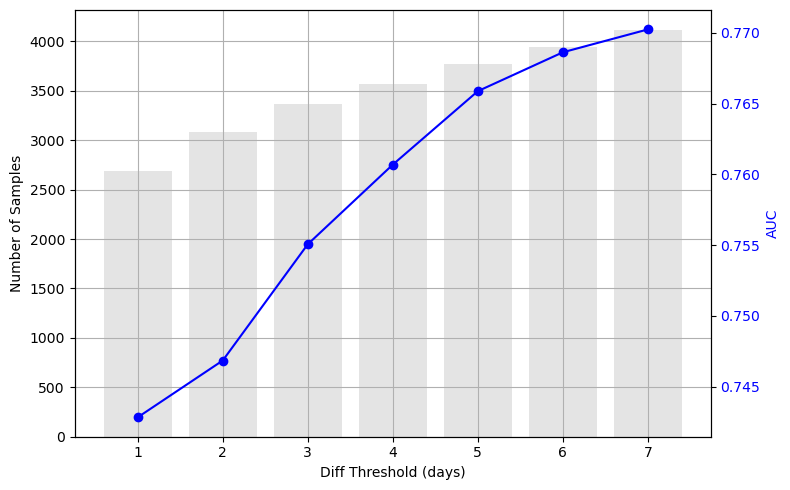

In [50]:
try:
    # Iterate over thresholds to evaluate the performance
    auc_values = []
    sample_sizes = []
    thresholds = range(1, 8)
    
    for threshold in thresholds:
        subset_df = val_df[(val_df['label'] == 0) | ((val_df['label'] == 1) & (val_df['Diff'] < threshold * 24))]
        subset_name = f"Diff < {threshold} days ({len(subset_df)} samples)"
        
        y_pred_classes_optimized = np.array(subset_df['predicted_label'].values)
        y_pred_prob = np.array(subset_df['predicted_prob'].values).ravel()
        y_true = np.array(subset_df['label'].values).astype(int)
    
        _, accuracy, auc, sensitivity, specificity, ppv, npv, f1 = classification_metrics(y_pred_prob, y_true)
    
        auc_values.append(auc)
        sample_sizes.append(len(subset_df))
        
        print(f"{subset_name}:  AUC: {auc:.2f}, Accuracy: {accuracy:.2f}, Sensitivity: {sensitivity:.2f}, Specificity: {specificity:.2f}, PPV: {ppv:.2f}, NPV: {npv:.2f}, F1: {f1:.2f}")
    
    # Plotting the AUC values and the size of each subset
    fig, ax1 = plt.subplots(figsize=(8, 5))
    
    # Plot sample sizes (bar plot)
    ax1.set_xlabel('Diff Threshold (days)')
    ax1.set_ylabel('Number of Samples')
    ax1.bar(thresholds, sample_sizes, alpha=0.6, color='lightgray', label='Number of Samples')
    ax1.tick_params(axis='y')
    ax1.grid(True)
    
    # Create a twin y-axis to plot the AUC values
    ax2 = ax1.twinx()
    ax2.set_ylabel('AUC', color='b')
    ax2.plot(thresholds, auc_values, marker='o', linestyle='-', color='b', label='AUC')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Show plot
    fig.tight_layout()
    plt.show()
except:
    print('Diff 1-7 incomplete')

In [51]:
val_df.to_csv(os.path.join(results_dir, 'val_df.csv'), index=False)

(array([925.,  23.,   7.,   5.,   2.,   3.,   4.,   4.,   1.,   5.,   6.,
          1.,   1.,   0.,   3.,   3.,   0.,   2.,   1.,   1.,   5.,   2.,
          3.,   2.,   2.,   1.,   0.,   3.,   2.,   4.,   2.,   5.,   0.,
          1.,   5.,   1.,   1.,   5.,   2.,   4.,   1.,   4.,   4.,   4.,
          7.,  10.,  10.,  12.,  20., 821.]),
 array([1.78215788e-20, 1.99999996e-02, 3.99999991e-02, 5.99999987e-02,
        7.99999982e-02, 1.00000001e-01, 1.19999997e-01, 1.40000001e-01,
        1.59999996e-01, 1.80000007e-01, 2.00000003e-01, 2.19999999e-01,
        2.39999995e-01, 2.59999990e-01, 2.80000001e-01, 3.00000012e-01,
        3.19999993e-01, 3.40000004e-01, 3.60000014e-01, 3.79999995e-01,
        4.00000006e-01, 4.19999987e-01, 4.39999998e-01, 4.60000008e-01,
        4.79999989e-01, 5.00000000e-01, 5.19999981e-01, 5.40000021e-01,
        5.60000002e-01, 5.79999983e-01, 6.00000024e-01, 6.20000005e-01,
        6.39999986e-01, 6.60000026e-01, 6.80000007e-01, 6.99999988e-01,
        7.

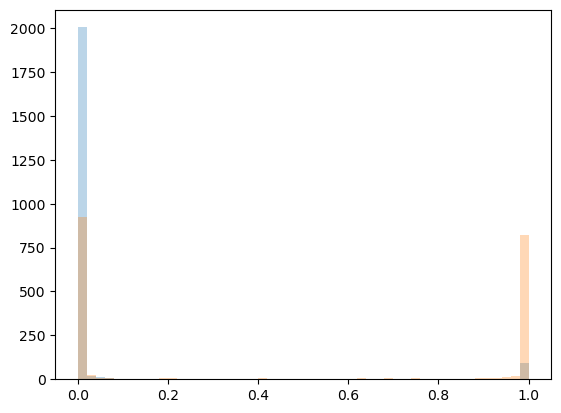

In [52]:
import matplotlib.pyplot as plt
plt.hist(val_df[val_df['label']==0]['predicted_prob'],alpha=0.3,bins=50)
plt.hist(val_df[val_df['label']==1]['predicted_prob'],alpha=0.3,bins=50)

In [53]:
val_df_subset = val_df[(val_df['label']==1) & (val_df['predicted_prob']<0.5)]
val_df_subset[val_df_subset['Diff']>24].size # .value_counts()

16054

In [54]:
(val_df_subset['Diff']>24).sum()/len(val_df_subset)

0.6904055390702275

In [55]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, f1_score

# Binary classification metrics with a custom threshold
def classification_metrics_custom_threshold(pred, true, threshold):
    # Apply the custom threshold to convert probabilities to binary labels
    pred_labels = (pred >= threshold).astype(int)
    true_labels = true.astype(int)
    
    # Calculate confusion matrix to extract TP, TN, FP, FN
    tn, fp, fn, tp = confusion_matrix(true_labels, pred_labels).ravel()

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Specificity (FPR = 1 - Specificity)
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0          # Positive Predictive Value (Precision)
    npv = tn / (tn + fn) if (tn + fn) != 0 else 0          # Negative Predictive Value
    f1 = f1_score(true_labels, pred_labels)                # F1 Score

    return accuracy, sensitivity, specificity, ppv, npv, f1

# Step 1: Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(trues, preds)

# Step 2: Calculate Youden's index threshold
youdens_index = tpr - fpr
youden_threshold = thresholds[np.argmax(youdens_index)]

# Step 3: Fine-tune High sensitivity threshold (~ 95%)
high_sensitivity_diff = abs(tpr - 0.95)
high_sensitivity_threshold = thresholds[np.argmin(high_sensitivity_diff)]

# Step 4: Fine-tune High specificity threshold (~ 95%)
# Apply smoothing to prevent division by zero or threshold reaching infinity
SMOOTHING_FACTOR = 1e-6
adjusted_fpr = fpr + SMOOTHING_FACTOR  # Add smoothing factor to avoid extreme values
high_specificity_diff = abs(1 - adjusted_fpr - 0.95)
high_specificity_threshold = thresholds[np.argmin(high_specificity_diff)]

# Step 5: Fixed threshold of 0.5
fixed_threshold = 0.5

# Step 6: Compute metrics for each threshold
thresholds_and_names = [
    (fixed_threshold, "Default Threshold"),
    (youden_threshold, "Youden's Threshold"),
    (high_sensitivity_threshold, "High Sens. Thresh."),
    (high_specificity_threshold, "High Spec. Thresh.")
]

# Dictionary to store metrics for each threshold
performance_results = {}

# Compute metrics for each threshold
for threshold, threshold_name in thresholds_and_names:
    accuracy, sensitivity, specificity, ppv, npv, f1 = classification_metrics_custom_threshold(preds, trues, threshold)
    performance_results[threshold_name] = {
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'PPV': ppv,
        'NPV': npv,
        'F1': f1
    }

# Display the results for each threshold
for threshold_name, metrics in performance_results.items():
    print(f"- {threshold_name}: {metrics['Threshold']:.10f},\t Accuracy: {metrics['Accuracy']:.3f}, Sensitivity: {metrics['Sensitivity']:.3f}, Specificity: {metrics['Specificity']:.3f}, PPV: {metrics['PPV']:.3f}, NPV: {metrics['NPV']:.3f}, F1 Score: {metrics['F1']:.3f}")


- Default Threshold: 0.5000000000,	 Accuracy: 0.727, Sensitivity: 0.479, Specificity: 0.948, PPV: 0.892, NPV: 0.671, F1 Score: 0.623
- Youden's Threshold: 0.0003275733,	 Accuracy: 0.736, Sensitivity: 0.573, Specificity: 0.882, PPV: 0.812, NPV: 0.698, F1 Score: 0.672
- High Sens. Thresh.: 0.0000000000,	 Accuracy: 0.528, Sensitivity: 0.950, Specificity: 0.152, PPV: 0.499, NPV: 0.773, F1 Score: 0.655
- High Spec. Thresh.: 0.6238108873,	 Accuracy: 0.725, Sensitivity: 0.472, Specificity: 0.950, PPV: 0.894, NPV: 0.669, F1 Score: 0.618


In [ ]:
folds_path = "ctg_dataset/Dataset with Folds/model_datasets"

# Iterate through all 10 folds
for fold_num in range(10):
    fold_path = os.path.join(folds_path, f"fold_{fold_num}")

    # Load the latest results from each fold
    subdirs = [d for d in os.listdir(fold_path) if os.path.isdir(os.path.join(fold_path, d))]
    valid_dirs = []
    for subdir in subdirs:
        try:
            datetime.strptime(subdir, '%Y%m%d %H%M')
            valid_dirs.append(subdir)
        except ValueError:
            continue
    valid_dirs_sorted = sorted(valid_dirs, key=lambda x: datetime.strptime(x, '%Y%m%d %H%M'))
    if valid_dirs_sorted:
        results_dir = os.path.join(fold_path, valid_dirs_sorted[-1])
    print(f"\nFold {fold_num} (Results: {results_dir})")

    # Load results and metrics
    preds = np.load(os.path.join(results_dir, 'preds.npy'))
    trues = np.load(os.path.join(results_dir, 'trues.npy'))
    with open(os.path.join(results_dir, 'PatchTST_ctg_960.log'), 'r') as log_file:
        log_data = log_file.read()

    # Parse log data and extract metrics and epoch information
    test_metrics = None
    epochs_trained = 0
    lines = log_data.splitlines()
    
    # Parse the log file to extract the number of epochs and the test metrics
    for line in lines:
        if "Epoch:" in line and "cost time" in line:  # Extract the last epoch number from log
            match = re.search(r'Epoch: (\d+)', line)
            if match:
                epochs_trained = int(match.group(1))  # Track the last epoch number
        
        if "Accuracy:" in line:  # Find where test results are reported
            match = re.search(r'Accuracy: ([\d.]+), AUC: ([\d.]+), Sensitivity: ([\d.]+), Specificity: ([\d.]+), PPV: ([\d.]+), NPV: ([\d.]+), F1: ([\d.]+)', line)
            if match:
                accuracy, auc, sensitivity, specificity, ppv, npv, f1 = map(float, match.groups())
                test_metrics = {
                    'Accuracy': accuracy,
                    'AUC': auc,
                    'Sensitivity': sensitivity,
                    'Specificity': specificity,
                    'PPV': ppv,
                    'NPV': npv,
                    'F1': f1
                }

    # Print the total number of epochs trained
    print(f"Total epochs trained: {epochs_trained}")

    # If metrics found, print them
    if test_metrics:
        for metric, value in test_metrics.items():
            print(f"{metric}: {np.round(value, decimals=4)}")